# Forward Modeling of an Emission Spectrum using the hybrid (lpf+dit) Cross Section

In [1]:
from exojax.spec import rtransfer as rt
from exojax.spec import dit
from exojax.spec import lpf

In [2]:
#ATMOSPHERE                                                                     
NP=100
T0=1295.0 #K
Parr, dParr, k=rt.pressure_layer(NP=NP)
Tarr = T0*(Parr)**0.1

A T-P profile we assume is ...  

In [3]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.plot(Tarr,Parr)
plt.yscale("log")
plt.gca().invert_yaxis()
plt.show()

<Figure size 640x480 with 1 Axes>

We set a wavenumber grid using nugrid.

In [4]:
from exojax.spec.rtransfer import nugrid
nus,wav,res=nugrid(22920,23000,1000,unit="AA",xsmode="hybrid")

nugrid is linear: mode= hybrid


Loading a molecular database of CO and CIA (H2-H2)... 

In [5]:
from exojax.spec import moldb, contdb
mdbCO=moldb.MdbExomol('.database/CO/12C-16O/Li2015',nus)
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)

Background atmosphere:  H2
Reading transition file
.broad is used.
Broadening code level= a0
default broadening parameters are used for  71  J lower states in  152  states
H2-H2


In [6]:
from exojax.spec import molinfo
molmassCO=molinfo.molmass("CO")

Computing the relative partition function, 

In [7]:
from jax import vmap
qt=vmap(mdbCO.qr_interp)(Tarr)

Pressure and Natural broadenings 

In [8]:
from jax import jit
from exojax.spec.exomol import gamma_exomol
from exojax.spec import gamma_natural

gammaLMP = jit(vmap(gamma_exomol,(0,0,None,None)))\
        (Parr,Tarr,mdbCO.n_Texp,mdbCO.alpha_ref)
gammaLMN=gamma_natural(mdbCO.A)
gammaLM=gammaLMP+gammaLMN[None,:]

Doppler broadening

In [9]:
from exojax.spec import doppler_sigma
sigmaDM=jit(vmap(doppler_sigma,(None,0,None)))\
        (mdbCO.nu_lines,Tarr,molmassCO)

And line strength

In [10]:
from exojax.spec import SijT
SijM=jit(vmap(SijT,(0,None,None,None,0)))\
    (Tarr,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt)

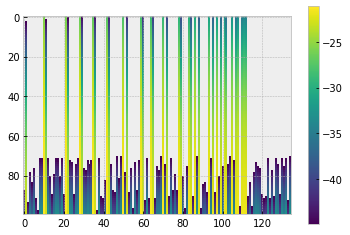

In [11]:
import jax.numpy as jnp
c=plt.imshow(jnp.log10(SijM))
plt.colorbar(c)

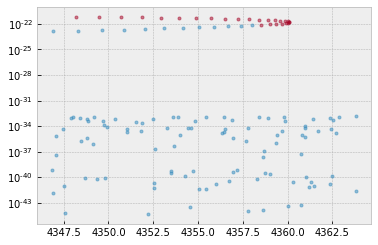

In [12]:
mask=SijM[-1,:]<jnp.max(SijM[-1,:])*1.e-1
plt.plot(mdbCO.nu_lines[mask],SijM[-1,mask],".",label="DIT",alpha=0.5)
plt.plot(mdbCO.nu_lines[~mask],SijM[-1,~mask],".",label="LPF",alpha=0.5)
plt.yscale("log")
plt.show()

In [13]:
print("# for DIT=",len(SijM[-1,mask]),", # for LPF=",len(SijM[-1,~mask]))

# for DIT= 110 , # for LPF= 25


In [14]:
from exojax.spec import make_numatrix0
from exojax.spec.lpf import xsmatrix
numatrix=make_numatrix0(nus,mdbCO.nu_lines)
xsmdirect=xsmatrix(numatrix,sigmaDM,gammaLM,SijM)

LPF 

In [15]:
from exojax.spec import make_numatrix0
numatrix=make_numatrix0(nus,mdbCO.nu_lines[~mask])
xsmlpf=lpf.xsmatrix(numatrix,sigmaDM[:,~mask],gammaLM[:,~mask],SijM[:,~mask])

DIT

In [16]:
adopt=True
import numpy as np
def dgmatrix(x,res,adopt=True):
    mmax=np.max(np.log10(x),axis=1)
    mmin=np.min(np.log10(x),axis=1)
    Nlayer=np.shape(mmax)[0]
    gm=[]
    dlog=np.max(mmax-mmin)
    Ng=(dlog/res).astype(int)+2
    for i in range(0,Nlayer):
        lxmin=mmin[i]
        lxmax=mmax[i]
        if adopt==False:
            grid=np.logspace(lxmin,lxmin+(Ng-1)*res,Ng)
        else:
            grid=np.logspace(lxmin,lxmax,Ng)
        gm.append(grid)
    gm=np.array(gm)
    return gm

In [17]:
dgm_sigmaD=dgmatrix(sigmaDM[:,mask],1.0)
dgm_gammaL=dgmatrix(gammaLM[:,mask],1.0)

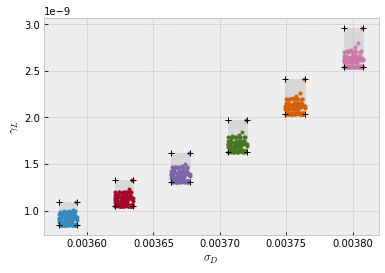

In [20]:
#show the DIT grids 
from exojax.plot.ditplot import plot_dgm
plot_dgm(dgm_sigmaD,dgm_gammaL,sigmaDM[:,mask],gammaLM[:,mask],0,6)

xsmatrix has the shape of (# of layers, # of nu grid)

In [21]:
xsmatrix=vmap(dit.xsvector,(None,0,0,0,None,0,0))

xsmdit=xsmatrix(mdbCO.nu_lines[mask],sigmaDM[:,mask],gammaLM[:,mask],\
SijM[:,mask],nus,dgm_sigmaD,dgm_gammaL)

In [22]:
xsm=xsmdit+xsmlpf

/home/kawahara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kawahara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kawahara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


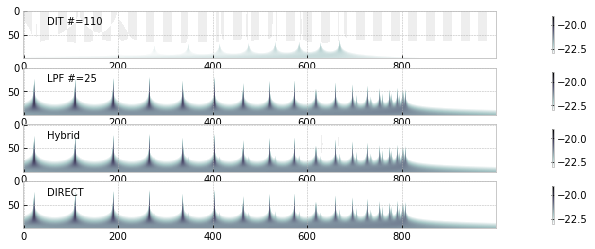

In [23]:
fig=plt.figure(figsize=(20,4))
ax=fig.add_subplot(411)
c=plt.imshow(np.log10(xsmdit),cmap="bone_r",vmin=-23,vmax=-19)
plt.colorbar(c,shrink=0.8)
plt.text(50,30,"DIT #="+str(np.sum(mask)))
ax=fig.add_subplot(412)
c=plt.imshow(np.log10(xsmlpf),cmap="bone_r",vmin=-23,vmax=-19)
plt.colorbar(c,shrink=0.8)
plt.text(50,30,"LPF #="+str(np.sum(~mask)))
ax=fig.add_subplot(413)
c=plt.imshow(np.log10(xsm),cmap="bone_r",vmin=-23,vmax=-19)
plt.colorbar(c,shrink=0.8)
plt.text(50,30,"Hybrid")
ax=fig.add_subplot(414)
c=plt.imshow(np.log10(xsmdirect),cmap="bone_r",vmin=-23,vmax=-19)
plt.colorbar(c,shrink=0.8)
plt.text(50,30,"DIRECT")
plt.show()

computing delta tau for CO

In [24]:
from exojax.spec.rtransfer import dtauM
Rp=0.88
Mp=33.2
g=2478.57730044555*Mp/Rp**2
#g=1.e5 #gravity cm/s2
MMR=0.0059 #mass mixing ratio
dtaum=dtauM(dParr,xsm,MMR*np.ones_like(Tarr),molmassCO,g)

In [25]:
dtaumdirect=dtauM(dParr,xsmdirect,MMR*np.ones_like(Tarr),molmassCO,g)

computing delta tau for CIA

In [26]:
from exojax.spec.rtransfer import dtauCIA
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molinfo.molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR
dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)

The total delta tau is a summation of them

In [27]:
dtau=dtaum+dtaucH2H2
dtaudirect=dtaumdirect+dtaucH2H2

you can plot a contribution function using exojax.plot.atmplot 

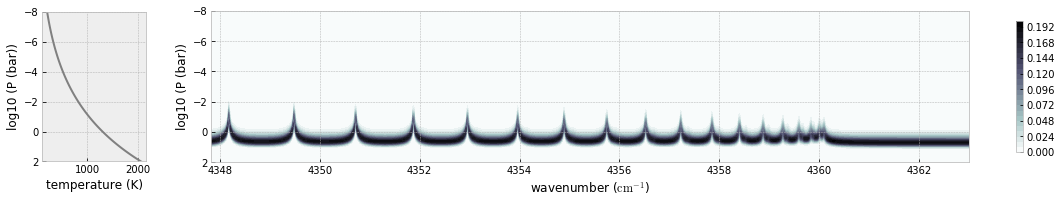

In [28]:
from exojax.plot.atmplot import plotcf
plotcf(nus,dtau,Tarr,Parr,dParr)
plt.show()

radiative transfering...

In [29]:
from exojax.spec import planck
from exojax.spec.rtransfer import rtrun
sourcef = planck.piBarr(Tarr,nus)
F0=rtrun(dtau,sourcef)
F0direct=rtrun(dtaudirect,sourcef)

Text(0.5, 0, 'wavelength ($\\AA$)')

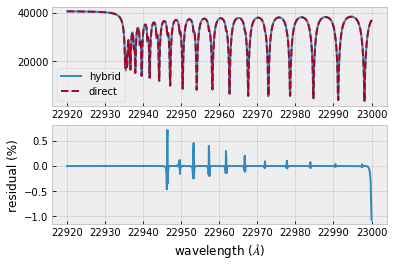

In [30]:
fig=plt.figure()
ax=fig.add_subplot(211)
plt.plot(wav[::-1],F0,label="hybrid")
plt.plot(wav[::-1],F0direct,ls="dashed",label="direct")
plt.legend()
ax=fig.add_subplot(212)
plt.plot(wav[::-1],(F0-F0direct)/np.median(F0direct)*100)
plt.ylabel("residual (%)")
plt.xlabel("wavelength ($\AA$)")

To apply response, we need to convert the wavenumber grid from ESLIN to ESLOG. 

In [31]:
nuslog=np.logspace(np.log10(nus[0]),np.log10(nus[-1]),len(nus))
F0log=jnp.interp(nuslog,nus,F0)

applying an instrumental response and planet/stellar rotation to the raw spectrum

In [32]:
from exojax.spec import response
from exojax.utils.constants import c
import jax.numpy as jnp

wavd=jnp.linspace(22920,23000,500) #observational wavelength grid
nusd = 1.e8/wavd[::-1]

RV=10.0 #RV km/s
vsini=20.0 #Vsini km/s
u1=0.0 #limb darkening u1
u2=0.0 #limb darkening u2

R=100000.
beta=c/(2.0*np.sqrt(2.0*np.log(2.0))*R) #IP sigma need check 

Frot=response.rigidrot(nuslog,F0log,vsini,u1,u2)
F=response.ipgauss_sampling(nusd,nuslog,Frot,beta,RV)

(22920, 23000)

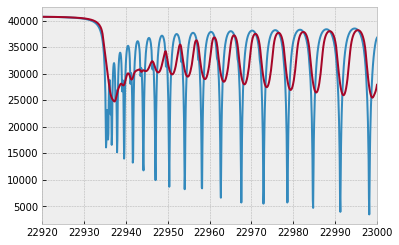

In [33]:
plt.plot(wav[::-1],F0)
plt.plot(wavd[::-1],F)
plt.xlim(22920,23000)